In [46]:
#pip install pyspark

In [47]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('/content/bank.csv', header = True, inferSchema = True)
df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [48]:
for t in df.dtypes:
  if t[1] == 'int':
    print(t[0])

age
balance
day
duration
campaign
pdays
previous


In [49]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
numeric_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [50]:
df.select(numeric_features).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|                 1|                -1|                 0|

In [51]:
df.select(numeric_features).describe().toPandas()

summary                 age             balance                 day  \
0   count               11162               11162               11162   
1    mean  41.231947679627304  1528.5385235620856  15.658036194230425   
2  stddev  11.913369192215518   3225.413325946149   8.420739541006462   
3     min                  18               -6847                   1   
4     max                  95               81204                  31   

             duration            campaign               pdays  \
0               11162               11162               11162   
1  371.99381831213043   2.508421429851281   51.33040673714388   
2  347.12838571630687  2.7220771816614824  108.75828197197717   
3                   2                   1                  -1   
4                3881                  63                 854   

             previous  
0               11162  
1  0.8325568894463358  
2   2.292007218670508  
3                   0  
4                  58

In [52]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Without OHE (using only StringIndexer):
jobIndex

┌────────┬─────────┐

| admin  | 0       |

| blue   | 1       |

| tech   | 2       |
  
└────────┴─────────┘

With OneHotEncoder:
jobclassVec


┌────────┬──────────────┐

| admin  | [1, 0, 0]    |

| blue   | [0, 1, 0]    |

| tech   | [0, 0, 1]    |

└────────┴──────────────┘


| Step | Transformer     | Purpose                                  | Input      | Output        |
| ---- | --------------- | ---------------------------------------- | ---------- | ------------- |
| 1    | `StringIndexer` | Converts string category → numeric index | `job`      | `jobIndex`    |
| 2    | `OneHotEncoder` | Converts numeric index → one-hot vector  | `jobIndex` | `jobclassVec` |

| job         | jobIndex | jobclassVec   |
| ----------- | -------- | ------------- |
| admin       | 0.0      | [1,0,0,0,...] |
| blue-collar | 1.0      | [0,1,0,0,...] |
| retired     | 2.0      | [0,0,1,0,...] |


| job         | marital | education | ... | age | balance | features                    | label |
| ----------- | ------- | --------- | --- | --- | ------- | --------------------------- | ----- |
| admin       | married | secondary | ... | 34  | 1000    | `[0,1,0,0,...,34,1000,...]` | 1.0   |
| blue-collar | single  | primary   | ... | 45  | 200     | `[1,0,0,0,...,45,200,...]`  | 0.0   |






In [53]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

#Define
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

🔹 What is StringIndexer in PySpark?

StringIndexer is a feature transformation tool in PySpark MLlib that converts categorical string labels into numeric indices.

It’s often the first step before applying ML algorithms, because most machine learning models work with numbers — not text labels.

🔹 Why is it used?

Machine learning algorithms cannot directly handle categorical (string) features.

For example, gender = ["male", "female"] must be converted to numeric form.

StringIndexer assigns a unique index to each distinct string value.

| id | gender |
| -- | ------ |
| 0  | male   |
| 1  | female |
| 2  | male   |
| 3  | female |
| 4  | other  |

After StringIndexer

| id | gender | gender_index |
| -- | ------ | ------------ |
| 0  | male   | 0.0          |
| 1  | female | 1.0          |
| 2  | male   | 0.0          |
| 3  | female | 1.0          |
| 4  | other  | 2.0          |


In [54]:
stages

[StringIndexer_5b4e2e44f107,
 OneHotEncoder_885a3ad39f19,
 StringIndexer_329e65624d74,
 OneHotEncoder_5f472ba9fcb1,
 StringIndexer_f755a6926d8b,
 OneHotEncoder_b7f39d686a83,
 StringIndexer_3fc26cabe822,
 OneHotEncoder_ff0790b61f35,
 StringIndexer_33cbd11c3b5d,
 OneHotEncoder_c158b38bb224,
 StringIndexer_4230b5700df4,
 OneHotEncoder_30140b2c3f80,
 StringIndexer_77cdc33148cb,
 OneHotEncoder_ffef539c077a,
 StringIndexer_3d6768d41eba,
 OneHotEncoder_cd93919638b3,
 StringIndexer_0a9f85eac9f9,
 VectorAssembler_c9ca033de8d3]

In [55]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)

In [56]:
df.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
+-----+--------------------+
only showing top 2 rows



In [57]:
df.select('label').show(10)

+-----+
|label|
+-----+
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
+-----+
only showing top 10 rows



In [58]:
#df.select('features').show(10)
df.select('features').show(10, truncate = False)

+--------------------------------------------------------------------------------------------------------+
|features                                                                                                |
+--------------------------------------------------------------------------------------------------------+
|(30,[3,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1042.0,1.0,-1.0])     |
|(30,[3,11,13,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.0,45.0,1467.0,1.0,-1.0])|
|(30,[2,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,41.0,1270.0,1389.0,1.0,-1.0])     |
|(30,[4,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,2476.0,579.0,1.0,-1.0])      |
|(30,[3,11,14,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,184.0,673.0,2.0,-1.0])|
|(30,[0,12,14,16,20,21,24,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,42.0,562.0,2.0,-1.0])                       |
|(30,[0,11,14,16,20,21,24,25,26,27,28

In [59]:
df.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
+-----+--------------------+
only showing top 2 rows



In [60]:
import pandas as pd
pd.DataFrame(df.take(5), columns= df.columns).transpose()

0  \
label                                                   1.0   
features  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          1  \
label                                                   1.0   
features  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          2  \
label                                                   1.0   
features  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          3  \
label                                                   1.0   
features  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          4  
label                                                   1.0  
features  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [61]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [62]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

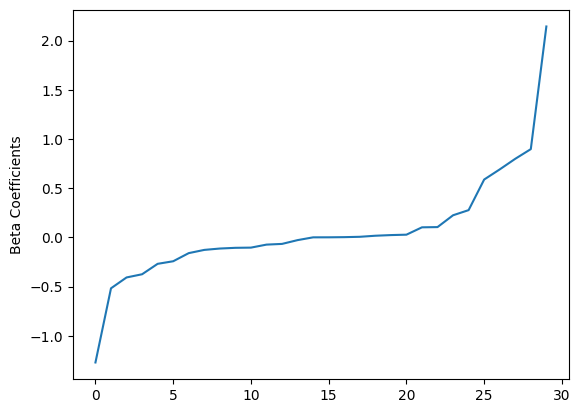

In [63]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

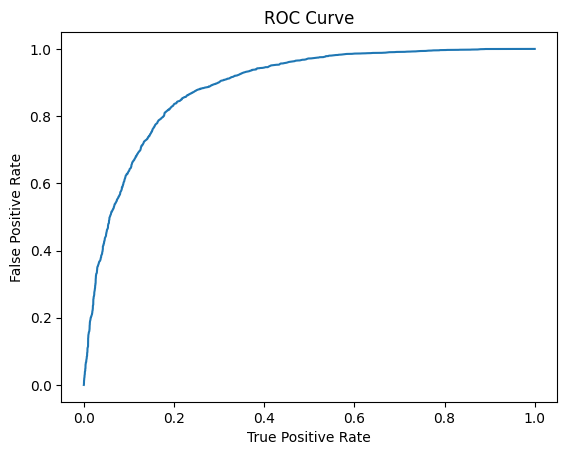

Training set areaUnderROC: 0.8877385690600346


In [64]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [65]:
predictions = lrModel.transform(test)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

In [66]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[1.93084854518128...|[0.87334331124860...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.92783695472097...|[0.87300981013433...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[-0.7737627890181...|[0.31566570209267...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[0.94708137344074...|[0.72052784002179...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.44657764692457...|[0.92031082026376...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.28386077546037...|[0.78310624913886...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.05745870556531...|[0.74220460119091...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[3.25200815517462...|[0.96274520587479...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.24978402804239...|[0.90463190417562...|       0.0|
|  0.0|(30,[0,11

In [67]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


In [68]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
+-----+--------------------+
only showing top 20 rows



In [69]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(20)

+-----+--------------------+--------------+--------------------+----------+
|label|            features| rawPrediction|         probability|prediction|
+-----+--------------------+--------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[520.0,1931.0]|[0.21215830273357...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[

In [70]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [71]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[13.6536849402749...|[0.68268424701374...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[13.6976774516090...|[0.68488387258045...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[6.83122719273221...|[0.34156135963661...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[12.7313361502006...|[0.63656680751003...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.5834624840041...|[0.72917312420020...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[13.9643996309149...|[0.69821998154574...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.1511491111102...|[0.70755745555551...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[15.5092357299917...|[0.77546178649958...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[15.7428197606366...|[0.78714098803183...|       0.0|
|  0.0|(30,[0,11

In [72]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8780763181710352


In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()